# Analysis of "Experiments on Emotional Inattention"


In [130]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-07-pilot'
data = load_csv_files(subfolder_name)

# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)

# Drop all columns that do not begin with 'participant'
data = data.filter(regex='^participant.')

data.columns = data.columns.str.replace('participant.', '')

# Convert the JSON strings to dictionaries
# Function to parse JSON strings while handling NaN values
def parse_dict_string(dict_string):
    # Check if the input is a string
    if not isinstance(dict_string, str):
        return None
    
    # Replace single quotes with double quotes before parsing as JSON
    corrected_dict_string = dict_string.replace("'", "\"")
    try:
        return json.loads(corrected_dict_string)
    except json.JSONDecodeError:
        return None

# Convert the JSON strings to dictionaries, handling NaN values
for column in ['times','mistakes','demographics']:
    data[column] = data[column].apply(parse_dict_string)

    # Create new columns for each key in the dictionaries and fill them with the corresponding values
    data = pd.concat([data, pd.json_normalize(data[column])], axis=1)
# Custom converter function to convert array strings to actual arrays
def parse_array_string(array_string):
    try:
        return ast.literal_eval(array_string)
    except (SyntaxError, ValueError):
        return None
    
data['experiment_sequence'] = data['experiment_sequence'].apply(parse_array_string)




# Calculate the time difference and create a new column 'task_duration'
data['task_duration'] = data['end_task'] - data['start_task']

# Calculate the time difference and create a new column 'task_duration'
data['study_duration'] = data['finished'] - data['start']

# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create a new column 'not_in_list' based on the condition
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude)

# Create a new column 'finished_experiment' based on the condition
data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x == 'Finished')


# Calculate the number of rows with 'finished_experiment' equal to True for each treatment
finished_experiment_count = data[data['finished_experiment'] == True].groupby('treatment').size()

# Calculate the number of rows with 'started_experiment' equal to True for each treatment
started_experiment_count = data[data['started_experiment'] == True].groupby('treatment').size()

# Calculate the ratio for each treatment
ratio_by_treatment = finished_experiment_count / started_experiment_count

print('Attrition by treatment: ',ratio_by_treatment)

    
# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment'] == True]


# Custom function to calculate the total from the 'mistakes' dictionary
def calculate_mistakes_total(mistakes_dict):
    # Check if the value is a dictionary
    if isinstance(mistakes_dict, dict):
        # Extract the values from the dictionary and sum them
        total = sum(mistakes_dict.values())
        return total
    else:
        return None

# Apply the custom function to create the new column 'mistakes_total'
data['mistakes_total'] = data['mistakes'].apply(calculate_mistakes_total)


# Select only the desired columns
selected_columns = ['feedback', 'treatment', 'payoff', 'study_duration']
selected_data = data[selected_columns]

# Create the 'output' folder if it doesn't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create the 'subfolder' inside the 'output' folder if it doesn't exist
subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)



Attrition by treatment:  treatment
bonus      0.12
penalty    0.12
dtype: float64


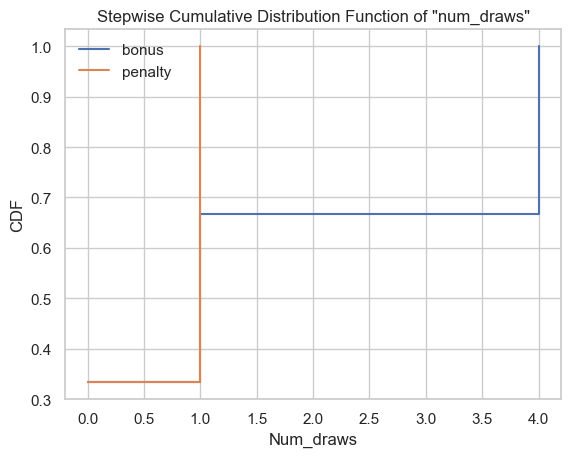

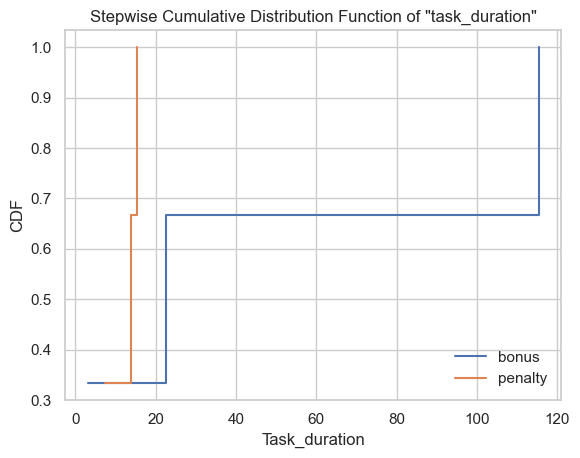

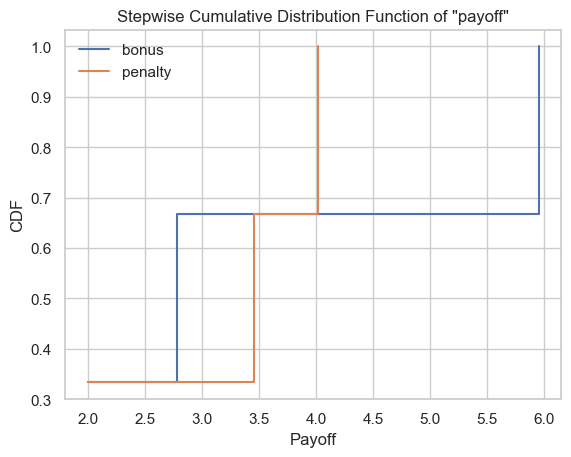

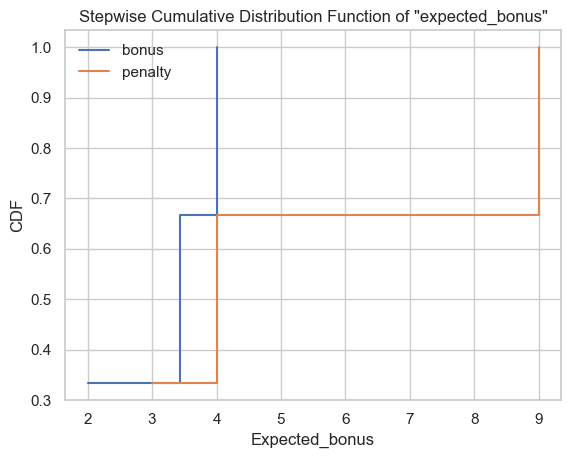

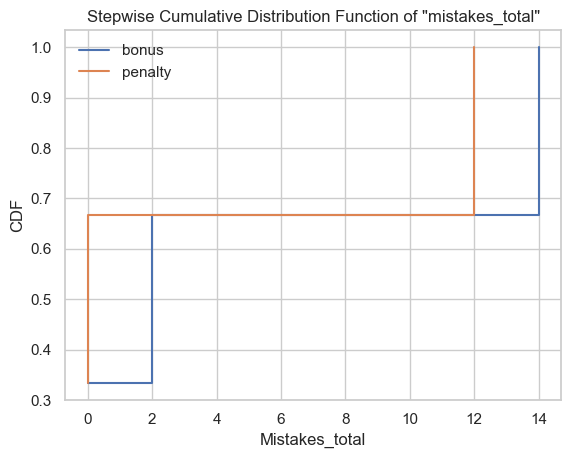

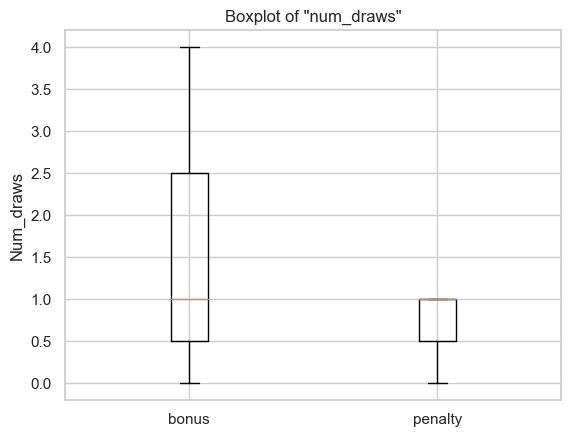

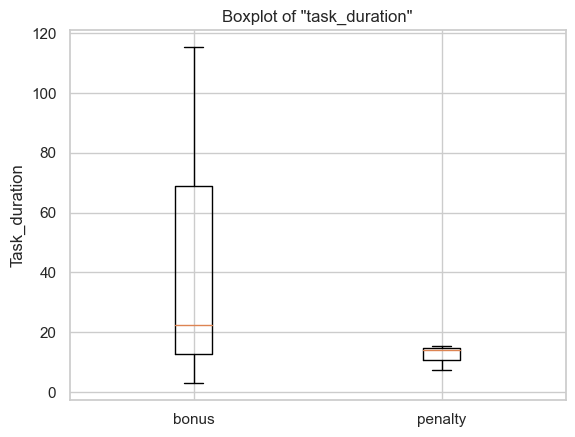

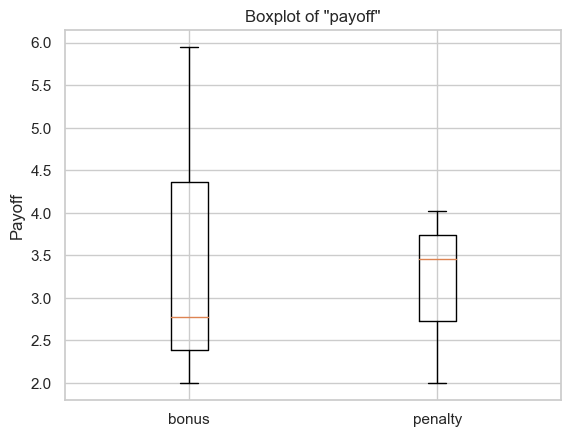

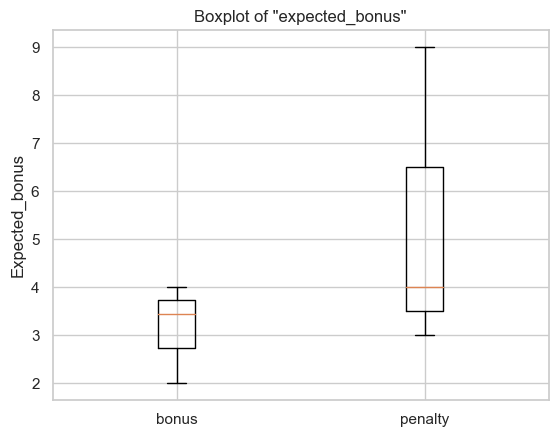

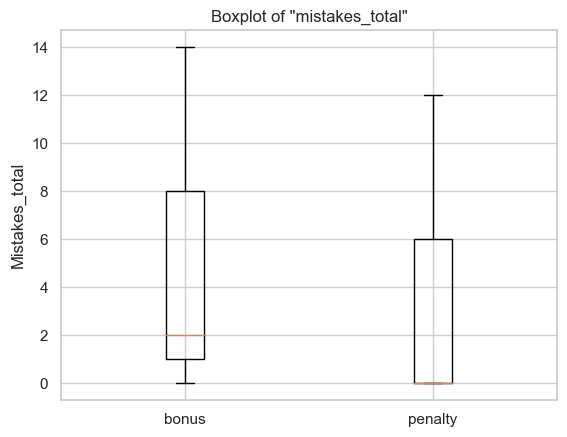

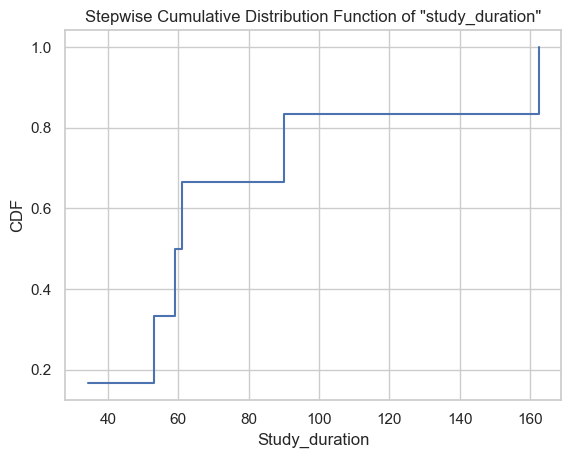

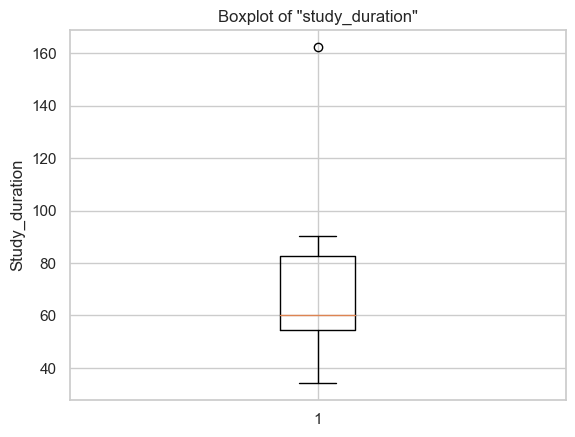

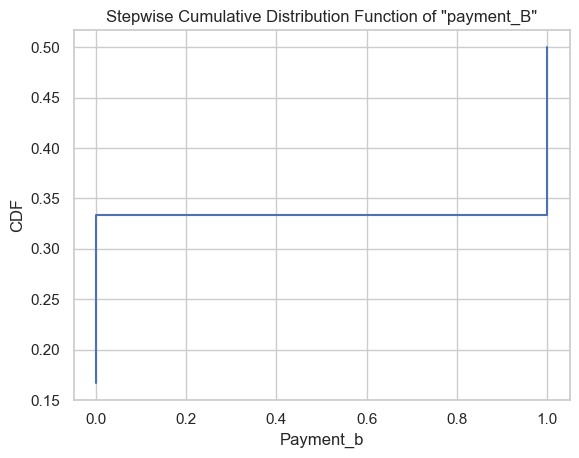

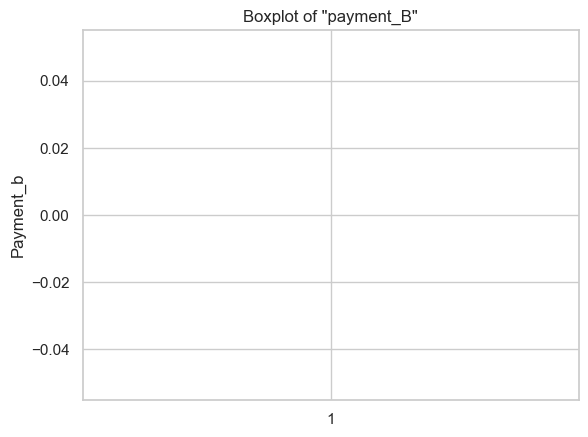

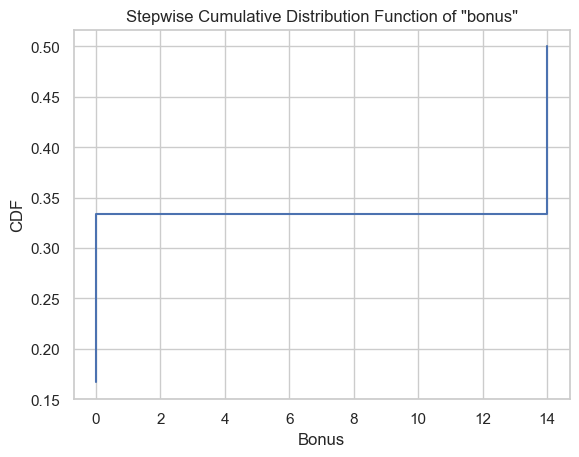

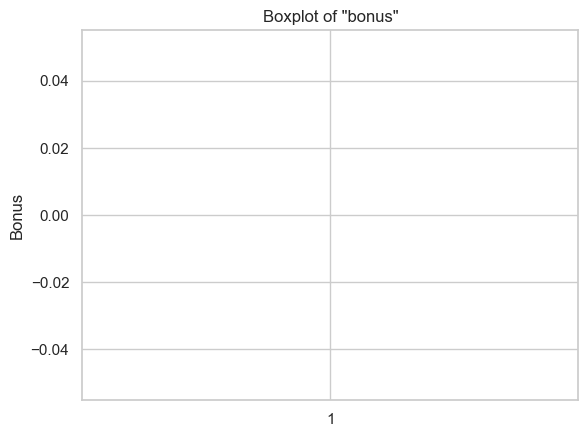

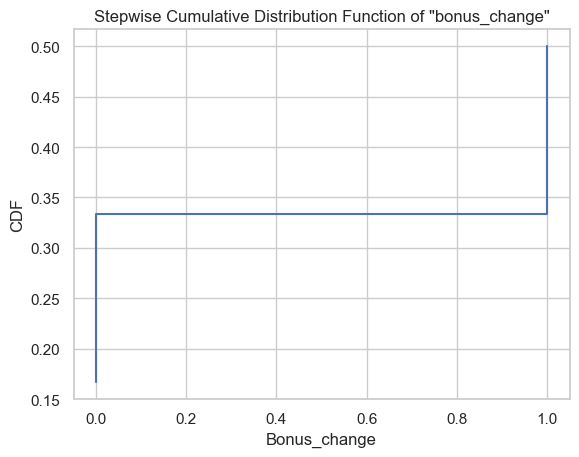

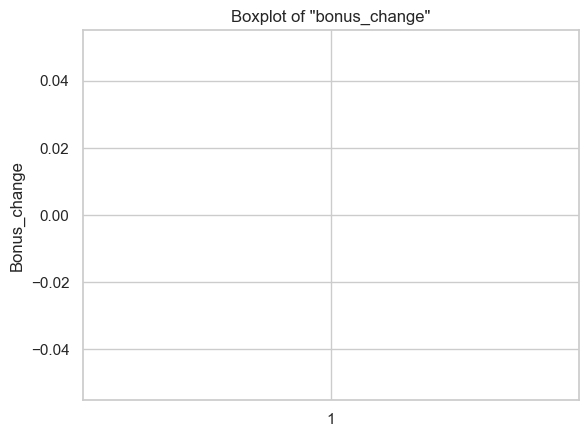

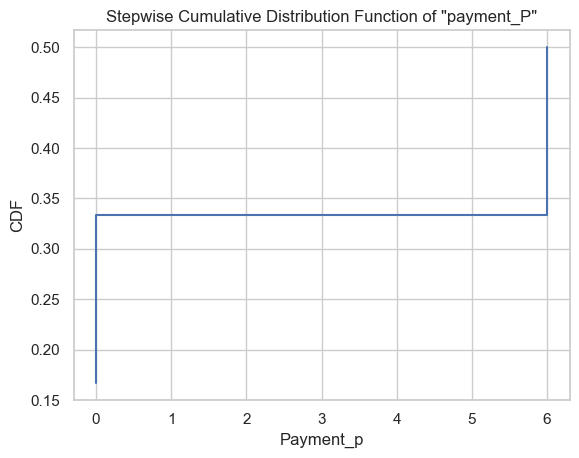

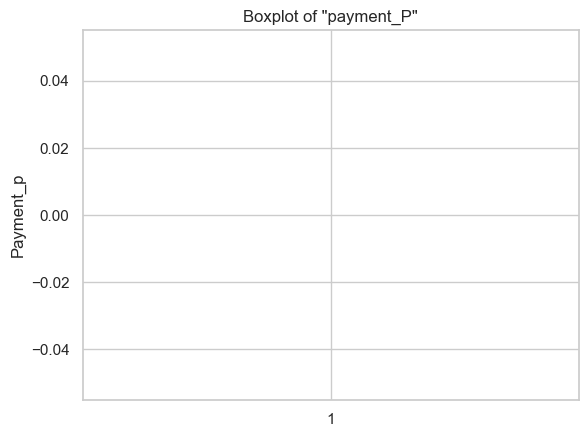

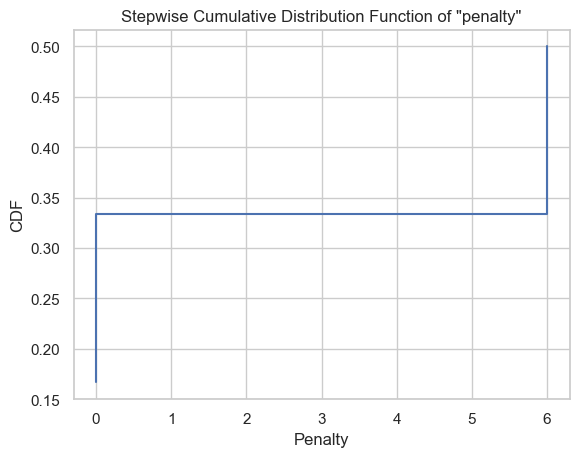

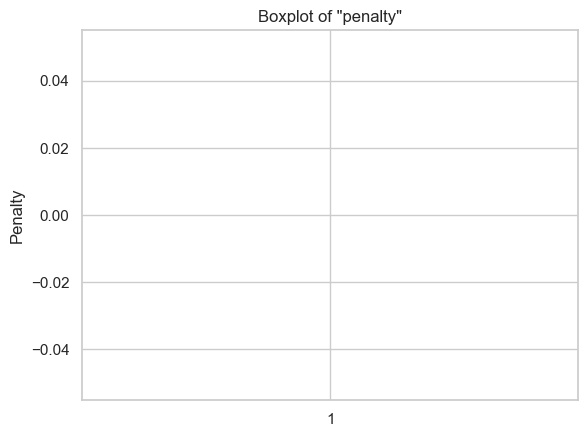

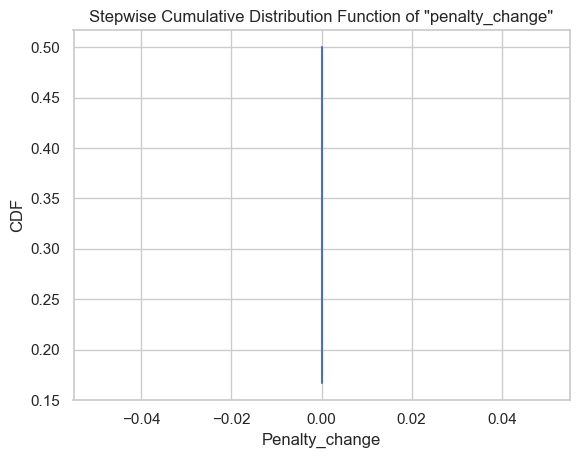

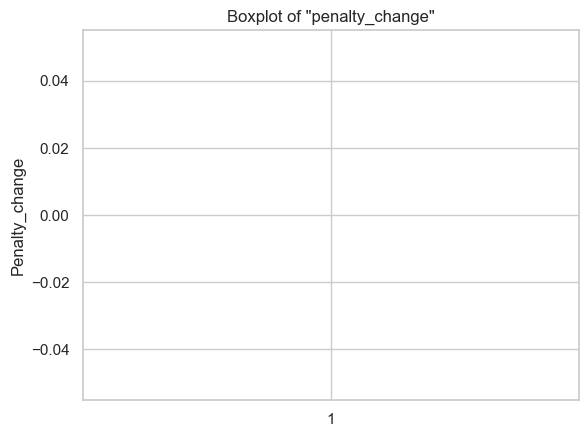

,num_draws,treatment
0,4.0,bonus
1,1.0,penalty
2,1.0,bonus
3,1.0,penalty
4,0.0,bonus
5,0.0,penalty


In [129]:
def plot_and_save_cdf(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Group the DataFrame by the "treatment" column
        grouped_data = data.groupby('treatment')[column_name]

        # Calculate and plot the stepwise CDF for each treatment group
        for treatment, group in grouped_data:
            sorted_data = np.sort(group)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            ax.step(sorted_data, cdf, where='post', label=treatment)

        # Add legend
        ax.legend()

    else:
        # Calculate and plot the stepwise CDF for the entire dataset
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post')

    # Add labels and title
    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_boxplot(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Data for boxplot
        treatment_values = data['treatment'].unique()
        data_to_plot = [data[data['treatment'] == treatment][column_name] for treatment in treatment_values]

        # Create the boxplots
        ax.boxplot(data_to_plot, labels=treatment_values)

    else:
        # Data for boxplot
        data_to_plot = data[column_name]

        # Create the boxplot
        ax.boxplot(data_to_plot)

    # Add labels and title
    ax.set_ylabel(column_name.capitalize())
    ax.set_title(f'Boxplot of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Call the function to plot and save the CDF for 'num_draws'
plot_and_save_cdf(data, 'num_draws', subfolder_name)

# Call the function to plot and save the CDF for 'time_task'
plot_and_save_cdf(data, 'task_duration', subfolder_name)

# Call the function to plot and save the CDF for 'payoff'
plot_and_save_cdf(data, 'payoff', subfolder_name)

# Call the function to plot and save the CDF for 'expected_bonus'
plot_and_save_cdf(data, 'expected_bonus', subfolder_name)

# Call the function to plot and save the CDF for 'mistakes_total'
plot_and_save_cdf(data, 'mistakes_total', subfolder_name)


# Call the function to plot and save the boxplot for 'num_draws'
plot_and_save_boxplot(data, 'num_draws', subfolder_name)

# Call the function to plot and save the boxplot for 'time_task'
plot_and_save_boxplot(data, 'task_duration', subfolder_name)

# Call the function to plot and save the boxplot for 'payoff'
plot_and_save_boxplot(data, 'payoff', subfolder_name)

# Call the function to plot and save the boxplot for 'expected_bonus'
plot_and_save_boxplot(data, 'expected_bonus', subfolder_name)

# Call the function to plot and save the boxplot for 'mistakes_total'
plot_and_save_boxplot(data, 'mistakes_total', subfolder_name)





# Call the function to plot and save the CDF for 'study_duration'
plot_and_save_cdf(data, 'study_duration', subfolder_name, by_treatment=False)


# Call the function to plot and save the boxplot for 'study_duration'
plot_and_save_boxplot(data, 'study_duration', subfolder_name, by_treatment=False)


for question in ['payment_B', 'bonus', 'bonus_change'] + ['payment_P', 'penalty', 'penalty_change']:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, question, subfolder_name, by_treatment=False)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, question, subfolder_name, by_treatment=False)

